In [ ]:
#Импорт библиотек
import pandas as pd

import numpy as np

import tensorflow as tf

import pandas as pd

from tensorflow.keras.models import Sequential, Model

from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, MaxPooling1D

from tensorflow.keras import utils

from tensorflow.keras.optimizers import Adam, Adadelta, Adagrad, RMSprop

from tensorflow.keras.preprocessing.text import Tokenizer

from keras.callbacks import  ReduceLROnPlateau,  EarlyStopping , ModelCheckpoint

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error, mean_absolute_error

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
#Загружаем датасет с переменную
dt_wearout = pd.read_excel('/content/РЖД.xlsx', sheet_name='Износ')
dt_wearout.head(10)

,Н_Ло,Н_КП,Н_Се,Номер,Секция,Н_серии,Начало,Конец,Период,Износ,Толщина гребня на начало,Толщина гребня на конец,Пробег за период,Пробег на начало,Пробег на конец
0,4573,81329,18728,2,1,253,2022-01-25,2022-12-08,317,3.00,32.00,29.00,133132.0,1873288.0,2006420.0
1,4573,114993,18728,2,1,253,2022-01-25,2022-12-08,317,3.00,32.00,29.00,133132.0,1873288.0,2006420.0
2,4573,82697,18728,2,1,253,2022-01-25,2022-07-04,160,1.20,31.25,30.05,66482.0,1873288.0,1939770.0
3,4573,82697,18728,2,1,253,2022-07-05,2022-12-08,156,2.00,31.50,29.50,66650.0,1939770.0,2006420.0
4,4573,117134,18728,2,1,253,2022-01-25,2022-07-04,160,0.50,31.00,30.50,66482.0,1873288.0,1939770.0
5,4573,117134,18728,2,1,253,2022-07-05,2022-12-08,156,3.50,31.50,28.00,66650.0,1939770.0,2006420.0
6,4573,117376,23439,2,2,253,2022-01-25,2022-11-10,289,1.50,30.75,29.25,120438.0,1873288.0,1993726.0
7,4573,117376,23439,2,2,253,2022-11-11,2022-12-08,27,0.00,29.25,29.25,12694.0,1993726.0,2006420.0
8,4573,81104,23439,2,2,253,2022-01-25,2022-11-10,289,1.75,31.25,29.50,120438.0,1873288.0,1993726.0
9,4573,81104,23439,2,2,253,2022-11-11,2022-12-08,27,0.00,30.75,30.75,12694.0,1993726.0,2006420.0


In [ ]:
# удалим пропуски датасета Износ
dt_wearout = dt_wearout.dropna().reset_index(drop=True)
dt_wearout = dt_wearout[dt_wearout['Износ']<10]
# заменим данные столбца "Пробег за период" на значение разницы столбцов 'Пробег на конец' и 'Пробег на начало'
dt_wearout['Пробег за период'] = dt_wearout['Пробег на конец'] - dt_wearout['Пробег на начало']

In [ ]:
dt_wearout.drop(['Н_Ло', 'Н_КП', 'Н_Се', 'Номер', 'Начало',
                                  'Конец', 'Толщина гребня на начало',
                                  'Толщина гребня на конец', 'Пробег на начало',
                                  'Пробег на конец'], axis=1)

,Секция,Н_серии,Период,Износ,Пробег за период
0,1,253,317,3.00,133132.0
1,1,253,317,3.00,133132.0
2,1,253,160,1.20,66482.0
3,1,253,156,2.00,66650.0
4,1,253,160,0.50,66482.0
...,...,...,...,...,...
82280,2,222,82,1.00,40319.0
82281,2,222,80,0.50,40657.0
82282,2,222,82,1.00,40319.0
82283,2,222,80,1.25,40657.0


In [ ]:
# построим матрицу корреляции
dt_wearout.drop(['Н_Ло', 'Н_КП', 'Н_Се', 'Номер', 'Начало',
                                  'Конец', 'Толщина гребня на начало',
                                  'Толщина гребня на конец', 'Пробег на начало',
                                  'Пробег на конец'], axis=1).corr().style.background_gradient(cmap='coolwarm')

,Секция,Н_серии,Период,Износ,Пробег за период
Секция,1.000000,-0.110575,0.000994,0.039188,0.057922
Н_серии,-0.110575,1.000000,-0.012746,0.015267,-0.157611
Период,0.000994,-0.012746,1.000000,0.527819,0.910826
Износ,0.039188,0.015267,0.527819,1.000000,0.555292
Пробег за период,0.057922,-0.157611,0.910826,0.555292,1.000000


In [ ]:
# преобразуем категориальные данные и построим матрицу корреляции
pd.get_dummies(dt_wearout.drop(['Н_Ло', 'Н_КП', 'Н_Се', 'Номер', 'Начало',
                                  'Конец', 'Толщина гребня на начало',
                                  'Толщина гребня на конец', 'Пробег на начало',
                                  'Пробег на конец'], axis=1), columns=['Секция',	'Н_серии'])

,Период,Износ,Пробег за период,Секция_1,Секция_2,Секция_3,Н_серии_222,Н_серии_253,Н_серии_640
0,317,3.00,133132.0,1,0,0,0,1,0
1,317,3.00,133132.0,1,0,0,0,1,0
2,160,1.20,66482.0,1,0,0,0,1,0
3,156,2.00,66650.0,1,0,0,0,1,0
4,160,0.50,66482.0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...
82280,82,1.00,40319.0,0,1,0,1,0,0
82281,80,0.50,40657.0,0,1,0,1,0,0
82282,82,1.00,40319.0,0,1,0,1,0,0
82283,80,1.25,40657.0,0,1,0,1,0,0


In [ ]:
pd.get_dummies(dt_wearout.drop(['Н_Ло', 'Н_КП', 'Н_Се', 'Номер', 'Начало',
                                  'Конец', 'Толщина гребня на начало',
                                  'Толщина гребня на конец', 'Пробег на начало',
                                  'Пробег на конец'], axis=1), columns=['Секция',	'Н_серии']).corr().style.background_gradient(cmap='coolwarm')

,Период,Износ,Пробег за период,Секция_1,Секция_2,Секция_3,Н_серии_222,Н_серии_253,Н_серии_640
Период,1.000000,0.527819,0.910826,-0.002681,0.003946,-0.001753,0.006636,0.002908,-0.012584
Износ,0.527819,1.000000,0.555292,-0.017558,-0.020830,0.053322,-0.124123,0.119539,0.002877
Пробег за период,0.910826,0.555292,1.000000,-0.029124,-0.024439,0.074406,-0.040718,0.165978,-0.168490
Секция_1,-0.002681,-0.017558,-0.029124,1.000000,-0.740870,-0.360748,0.116811,-0.165169,0.067695
Секция_2,0.003946,-0.020830,-0.024439,-0.740870,1.000000,-0.359155,0.122998,-0.170353,0.066517
Секция_3,-0.001753,0.053322,0.074406,-0.360748,-0.359155,1.000000,-0.333110,0.466064,-0.186430
Н_серии_222,0.006636,-0.124123,-0.040718,0.116811,0.122998,-0.333110,1.000000,-0.714731,-0.355108
Н_серии_253,0.002908,0.119539,0.165978,-0.165169,-0.170353,0.466064,-0.714731,1.000000,-0.400010
Н_серии_640,-0.012584,0.002877,-0.168490,0.067695,0.066517,-0.186430,-0.355108,-0.400010,1.000000


In [ ]:
# выведем новое представление закодированной категориальной части
pd.get_dummies(dt_wearout.drop(['Н_Ло', 'Н_КП', 'Н_Се', 'Номер', 'Начало',
                                'Конец', 'Толщина гребня на начало',
                                'Толщина гребня на конец', 'Пробег на начало',
                                'Пробег на конец'], axis=1), columns=\
                                ['Секция',	'Н_серии']).drop(['Период','Износ',
                                                              'Пробег за период'],
                                                             axis=1).values.astype(int)

array([[1, 0, 0, 0, 1, 0],
       [1, 0, 0, 0, 1, 0],
       [1, 0, 0, 0, 1, 0],
       ...,
       [0, 1, 0, 1, 0, 0],
       [0, 1, 0, 1, 0, 0],
       [0, 1, 0, 1, 0, 0]])

In [ ]:
# создадим функция оценки результатов и вывода оценки

def eval_net(model, x_train, y_train, y_scaler = None, n = 10, limit = 10.):

    pred = model.predict(x_train)             # Предсказание на тренировочной выборке
    if y_scaler:                              # Если есть нормирование - то денормировать
        pred = y_scaler.inverse_transform(pred)

    print('Средняя абсолютная ошибка:', mean_absolute_error(pred, y_train), '\n')

    for i in range(n):
        print('Реальное значение: {:6.2f}  Предсказанное значение: {:6.2f}  Разница: {:6.2f}'.format(y_train[i, 0],
                                                                                                    pred[i, 0],
                                                                                                    abs(y_train[i, 0] - pred[i, 0])))
    # Построение картинки разброса предсказанных и верных значений зарплаты
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.scatter(y_train, pred)                 # Отрисовка точечного графика
    ax.set_xlim(0, limit)                     # Пределы по x, y
    ax.set_ylim(0, limit)
    ax.plot(plt.xlim(), plt.ylim(), 'r')      # Отрисовка диагональной линии
    plt.xlabel('Правильные значения Износа')
    plt.ylabel('Предсказания')
    plt.grid()
    plt.show()

In [ ]:
# создадим функцию для вывода графиков средней абсолютной ошибки на обучающем и проверочном наборе
def plot_history(history):
    plt.plot(history.history['mae'],
            label='Средняя абсолютная ошибка на обучающем наборе')
    plt.plot(history.history['val_mae'],
            label='Средняя абсолютная ошибка на проверочном наборе')
    plt.xlabel('Эпоха обучения')
    plt.ylabel('Средняя абсолютная ошибка')
    plt.legend()
    plt.show()

In [ ]:
# Визуальная оценка ошибки на обучающей и проверочной выборках

def compare_sharp_loss (history, x_size=6, y_size=4):

  # Смотрим графики точности на обучающей и проверочной выборках
  plt.figure(figsize=(x_size,y_size))
  plt.plot(history.history['loss'],
         label='Ошибка на обучающей выборке')

  # Выводим график точности на проверочной выборке
  plt.plot(history.history['val_loss'],
         label='Ошибка проверочном наборе')
  plt.xlabel('Эпоха обучения')
  plt.ylabel('Средняя ошибка c callback')
  plt.legend()
  plt.show()

In [ ]:
# создадим выборки данных
x_data_num = pd.get_dummies(dt_wearout.drop(['Н_Ло', 'Н_КП', 'Н_Се', 'Номер', 'Начало',
                                  'Конец', 'Толщина гребня на начало',
                                  'Толщина гребня на конец', 'Пробег на начало',
                                  'Пробег на конец'], axis=1), columns=\
                                   ['Секция','Н_серии'])[['Период',
                                                          'Пробег за период']].values
x_data_cat = pd.get_dummies(dt_wearout.drop(['Н_Ло', 'Н_КП', 'Н_Се', 'Номер', 'Начало',
                                'Конец', 'Толщина гребня на начало',
                                'Толщина гребня на конец', 'Пробег на начало',
                                'Пробег на конец'], axis=1), columns=\
                                ['Секция',	'Н_серии']).drop(['Период','Износ',
                                                              'Пробег за период'],
                                                             axis=1).values.astype(int)
y_data = pd.get_dummies(dt_wearout.drop(['Н_Ло', 'Н_КП', 'Н_Се', 'Номер', 'Начало',
                                  'Конец', 'Толщина гребня на начало',
                                  'Толщина гребня на конец', 'Пробег на начало',
                                  'Пробег на конец'], axis=1), columns=\
                                   ['Секция',	'Н_серии'])['Износ'].values

In [ ]:
# выведем размер выборок
print(x_data_num.shape)
print(x_data_cat.shape)
print(y_data.shape)

(82284, 2)
(82284, 6)
(82284,)


# Числовые данные

In [ ]:
# нормируем числовые данные
x_scaler = StandardScaler()
x_num_scaled = x_scaler.fit_transform(x_data_num)

y_scaler = StandardScaler()
y_scaled = y_data.reshape(-1,1)
y_scaled = y_scaler.fit_transform(y_scaled)

print('Размер нормализованных числовых данных обучающей выборки', x_num_scaled.shape)
print('Размер нормализованных правильных ответов', y_scaled.shape)

Размер нормализованных числовых данных обучающей выборки (82284, 2)
Размер нормализованных правильных ответов (82284, 1)


In [ ]:
# разобъем числовую выборку на обучающую и тестовую
x_train_num, x_test_num, y_train_num, y_test_num = train_test_split(x_num_scaled,y_scaled,test_size=0.2,shuffle = False)
print(x_train_num.shape)
print(y_train_num.shape)
print(x_test_num.shape)
print(y_test_num.shape)

(65827, 2)
(65827, 1)
(16457, 2)
(16457, 1)


In [ ]:
# импортируем коллбэки
from keras.callbacks import  ReduceLROnPlateau,  EarlyStopping, ModelCheckpoint

earlystop=EarlyStopping(monitor='val_loss',
                        min_delta=0,
                        patience=4,
                        verbose=1,
                        baseline=None,
                        restore_best_weights=True)

reduceLROnPlateau = ReduceLROnPlateau(monitor='val_loss',
                                      factor=0.6,
                                      patience=2,
                                      verbose=1)

model_Checkpoint = ModelCheckpoint(filepath='/content/Модели/model.h5',
                                   monitor='val_loss',
                                   verbose=1,
                                   save_best_only=True,
                                   mode='auto',
                                   baseline=None)

Epoch 1/30
207/219 [===========================>..] - ETA: 0s - loss: 0.7297 - mae: 0.6666
Epoch 1: val_loss improved from inf to 0.54166, saving model to /content/Модели/model.h5
219/219 [==============================] - 9s 6ms/step - loss: 0.7276 - mae: 0.6657 - val_loss: 0.5417 - val_mae: 0.5795 - lr: 0.0010
Epoch 2/30
 40/219 [====>.........................] - ETA: 0s - loss: 0.7196 - mae: 0.6617

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


213/219 [============================>.] - ETA: 0s - loss: 0.7091 - mae: 0.6573
Epoch 2: val_loss did not improve from 0.54166
219/219 [==============================] - 1s 5ms/step - loss: 0.7099 - mae: 0.6579 - val_loss: 0.5956 - val_mae: 0.5993 - lr: 0.0010
Epoch 3/30
209/219 [===========================>..] - ETA: 0s - loss: 0.7050 - mae: 0.6552
Epoch 3: val_loss improved from 0.54166 to 0.52911, saving model to /content/Модели/model.h5
219/219 [==============================] - 1s 5ms/step - loss: 0.7048 - mae: 0.6552 - val_loss: 0.5291 - val_mae: 0.5698 - lr: 0.0010
Epoch 4/30
208/219 [===========================>..] - ETA: 0s - loss: 0.7054 - mae: 0.6560
Epoch 4: val_loss did not improve from 0.52911
219/219 [==============================] - 1s 5ms/step - loss: 0.7036 - mae: 0.6551 - val_loss: 0.5405 - val_mae: 0.5707 - lr: 0.0010
Epoch 5/30
219/219 [==============================] - ETA: 0s - loss: 0.7028 - mae: 0.6553
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.000

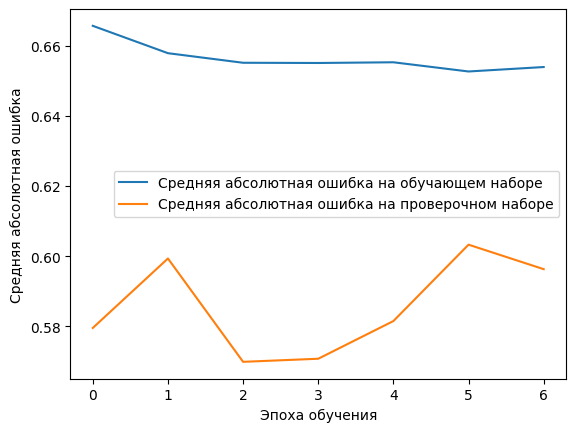

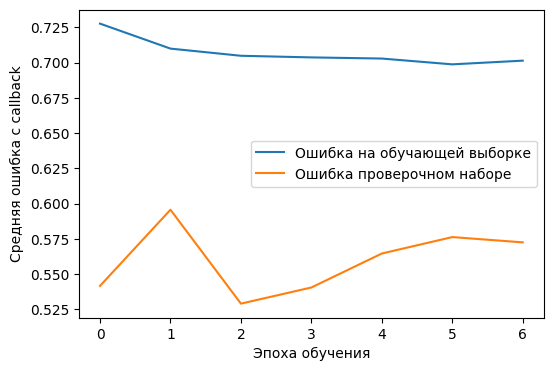

In [ ]:
# Обучение модели на числовых данных

model_num = Sequential()
model_num.add(BatchNormalization(input_dim=x_train_num.shape[1]))
model_num.add(Dense(128, activation='relu'))
model_num.add(Dense(1000, activation='relu'))
model_num.add(Dropout(0.2))
model_num.add(Dense(100, activation='relu'))
model_num.add(Dense(1, activation='linear'))

model_num.compile(optimizer=Adam(learning_rate=1e-3), loss='mse', metrics=['mae'])

history_num = model_num.fit(x_train_num,
                    y_train_num,
                    epochs=30,
                    batch_size=256,
                    validation_split=0.15,
                    verbose=1,
                    callbacks=[earlystop, reduceLROnPlateau, model_Checkpoint])

plot_history(history_num)
compare_sharp_loss(history_num)

2058/2058 [==============================] - 4s 2ms/step
Средняя абсолютная ошибка: 1.7966300326117137 

Реальное значение:   0.89  Предсказанное значение:   2.55  Разница:   1.66
Реальное значение:   0.89  Предсказанное значение:   2.55  Разница:   1.66
Реальное значение:  -0.44  Предсказанное значение:   2.19  Разница:   2.63
Реальное значение:   0.15  Предсказанное значение:   2.12  Разница:   1.97
Реальное значение:  -0.96  Предсказанное значение:   2.19  Разница:   3.15
Реальное значение:   1.26  Предсказанное значение:   2.12  Разница:   0.87
Реальное значение:  -0.22  Предсказанное значение:   2.59  Разница:   2.81
Реальное значение:  -1.32  Предсказанное значение:   0.63  Разница:   1.96
Реальное значение:  -0.03  Предсказанное значение:   2.59  Разница:   2.63
Реальное значение:  -1.32  Предсказанное значение:   0.63  Разница:   1.96


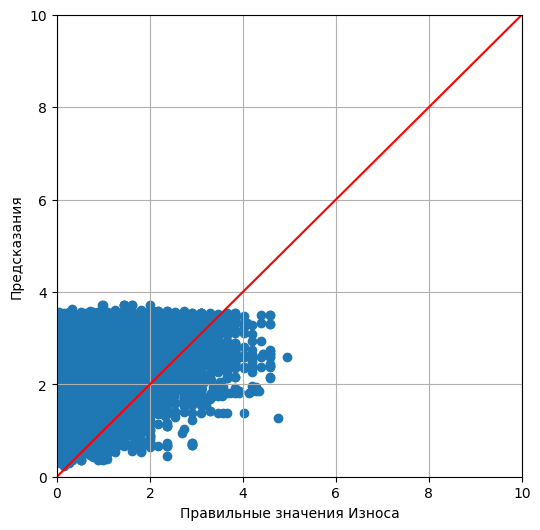

In [ ]:
eval_net(model_num, x_train_num, y_train_num, y_scaler)

# Категориальные данные

In [ ]:
# разобъем категориальную выборку на обучающую и тестовую
x_train_cat, x_test_cat, y_train_cat, y_test_cat = train_test_split(x_data_cat,y_scaled,test_size=0.2,shuffle = False)
print(x_train_cat.shape)
print(y_train_cat.shape)
print(x_test_cat.shape)
print(y_test_cat.shape)

(65827, 6)
(65827, 1)
(16457, 6)
(16457, 1)


Epoch 1/30
219/219 [==============================] - ETA: 0s - loss: 1.0859 - mae: 0.8463
Epoch 1: val_loss did not improve from 0.52911
219/219 [==============================] - 4s 7ms/step - loss: 1.0859 - mae: 0.8463 - val_loss: 0.7665 - val_mae: 0.7149 - lr: 1.0000e-04
Epoch 2/30
214/219 [============================>.] - ETA: 0s - loss: 1.0845 - mae: 0.8460
Epoch 2: val_loss did not improve from 0.52911
219/219 [==============================] - 1s 5ms/step - loss: 1.0852 - mae: 0.8460 - val_loss: 0.7643 - val_mae: 0.7128 - lr: 1.0000e-04
Epoch 3/30
218/219 [============================>.] - ETA: 0s - loss: 1.0851 - mae: 0.8458
Epoch 3: val_loss did not improve from 0.52911
219/219 [==============================] - 1s 5ms/step - loss: 1.0854 - mae: 0.8460 - val_loss: 0.7677 - val_mae: 0.7147 - lr: 1.0000e-04
Epoch 4/30
208/219 [===========================>..] - ETA: 0s - loss: 1.0829 - mae: 0.8455
Epoch 4: val_loss did not improve from 0.52911
219/219 [=========================

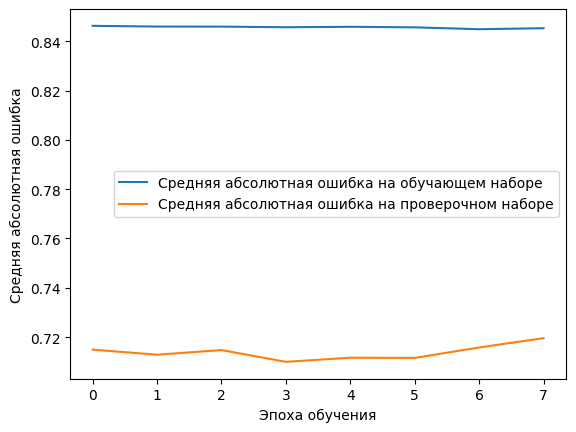

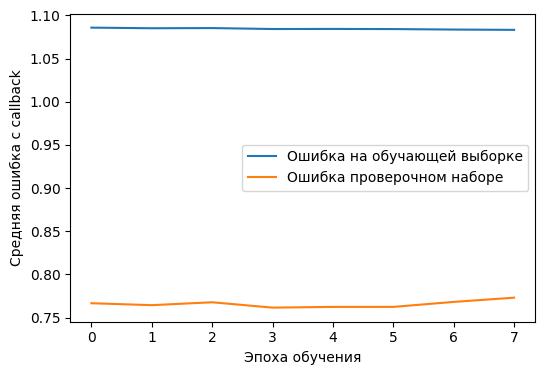

In [ ]:
# Обучение модели на категориальных данных

model_cat = Sequential()
model_cat.add(BatchNormalization(input_dim=x_train_cat.shape[1]))
model_cat.add(Dense(128, activation='relu'))
model_cat.add(Dense(1000, activation='relu'))
model_cat.add(Dense(100, activation='relu'))
model_cat.add(Dense(1, activation='linear'))

model_cat.compile(optimizer=Adam(learning_rate=1e-4), loss='mse', metrics=['mae'])

history_cat = model_cat.fit(x_train_cat,
                    y_train_cat,
                    epochs=30,
                    batch_size=256,
                    validation_split=0.15,
                    verbose=1,
                    callbacks=[earlystop, reduceLROnPlateau, model_Checkpoint])

plot_history(history_cat)
compare_sharp_loss(history_cat)

2058/2058 [==============================] - 5s 2ms/step
Средняя абсолютная ошибка: 1.8755634250492477 

Реальное значение:   0.89  Предсказанное значение:   2.00  Разница:   1.11
Реальное значение:   0.89  Предсказанное значение:   2.00  Разница:   1.11
Реальное значение:  -0.44  Предсказанное значение:   2.00  Разница:   2.44
Реальное значение:   0.15  Предсказанное значение:   2.00  Разница:   1.85
Реальное значение:  -0.96  Предсказанное значение:   2.00  Разница:   2.95
Реальное значение:   1.26  Предсказанное значение:   2.00  Разница:   0.74
Реальное значение:  -0.22  Предсказанное значение:   1.98  Разница:   2.20
Реальное значение:  -1.32  Предсказанное значение:   1.98  Разница:   3.30
Реальное значение:  -0.03  Предсказанное значение:   1.98  Разница:   2.01
Реальное значение:  -1.32  Предсказанное значение:   1.98  Разница:   3.30


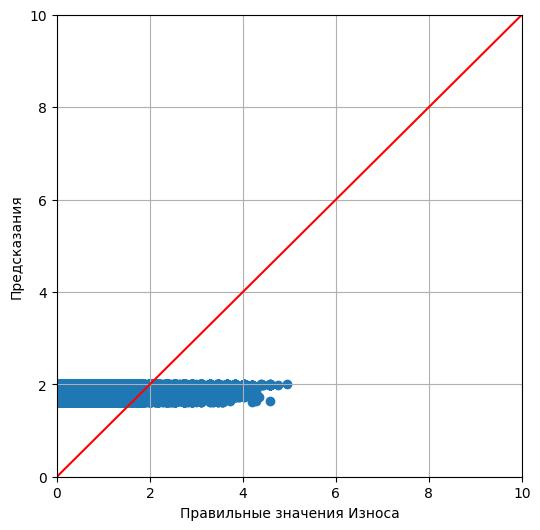

In [ ]:
eval_net(model_cat, x_train_cat, y_train_cat, y_scaler)

# FunctionalAPI

In [ ]:
# построим FunctionalAPI

input1 = Input((x_train_num.shape[1],))
input2 = Input((x_train_cat.shape[1],))

x1 = input1                               # Ветка числовых данных
x1 = Dense(128, activation="relu")(x1)
x1 = Dense(1000, activation="elu")(x1)
x1 = Dropout(0.3)(x1)
x1 = Dense(100, activation="relu")(x1)

x2 = input2                               # Ветка категориальных данных
x2 = Dense(20, activation="relu")(x2)
x2 = Dense(500, activation="tanh")(x2)
x2 = Dropout(0.3)(x2)

x = concatenate([x1, x2])             # Объединение веток

x = Dense(15, activation='relu')(x)       # Промежуточный слой
x = Dropout(0.5)(x)
x = Dense(1, activation='linear')(x)      # Финальный регрессирующий нейрон

# В Model передаются входы и выход
model_func = Model((input1, input2), x)

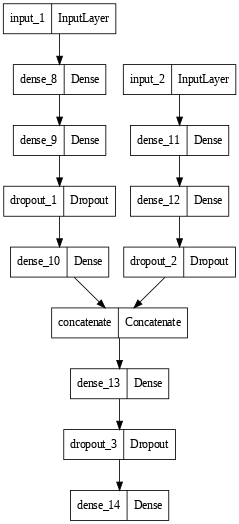

In [ ]:
# выведем схему построения модели
utils.plot_model(model_func, dpi=60)

In [ ]:
model_func.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 2)]                  0         []                            
                                                                                                  
 dense_8 (Dense)             (None, 128)                  384       ['input_1[0][0]']             
                                                                                                  
 input_2 (InputLayer)        [(None, 6)]                  0         []                            
                                                                                                  
 dense_9 (Dense)             (None, 1000)                 129000    ['dense_8[0][0]']             
                                                                                              

Epoch 1/50
272/274 [============================>.] - ETA: 0s - loss: 0.7473 - mae: 0.6762
Epoch 1: val_loss did not improve from 0.52911
274/274 [==============================] - 4s 7ms/step - loss: 0.7473 - mae: 0.6761 - val_loss: 0.5326 - val_mae: 0.5805 - lr: 0.0010
Epoch 2/50
268/274 [============================>.] - ETA: 0s - loss: 0.7186 - mae: 0.6629
Epoch 2: val_loss improved from 0.52911 to 0.52222, saving model to /content/Модели/model.h5
274/274 [==============================] - 2s 8ms/step - loss: 0.7191 - mae: 0.6631 - val_loss: 0.5222 - val_mae: 0.5560 - lr: 0.0010
Epoch 3/50
 16/274 [>.............................] - ETA: 1s - loss: 0.7131 - mae: 0.6594

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


264/274 [===========================>..] - ETA: 0s - loss: 0.7102 - mae: 0.6593
Epoch 3: val_loss did not improve from 0.52222
274/274 [==============================] - 2s 8ms/step - loss: 0.7102 - mae: 0.6593 - val_loss: 0.5295 - val_mae: 0.5652 - lr: 0.0010
Epoch 4/50
266/274 [============================>.] - ETA: 0s - loss: 0.7107 - mae: 0.6595
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 4: val_loss did not improve from 0.52222
274/274 [==============================] - 1s 5ms/step - loss: 0.7110 - mae: 0.6599 - val_loss: 0.5242 - val_mae: 0.5580 - lr: 0.0010
Epoch 5/50
266/274 [============================>.] - ETA: 0s - loss: 0.7066 - mae: 0.6586
Epoch 5: val_loss improved from 0.52222 to 0.52214, saving model to /content/Модели/model.h5
274/274 [==============================] - 2s 6ms/step - loss: 0.7061 - mae: 0.6582 - val_loss: 0.5221 - val_mae: 0.5580 - lr: 6.0000e-04
Epoch 6/50
268/274 [============================>.] - ETA: 0s - loss

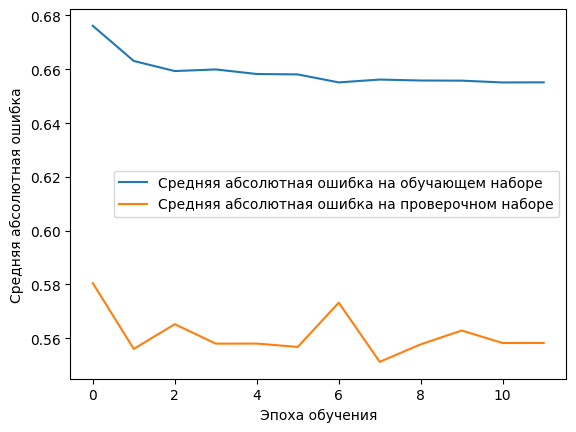

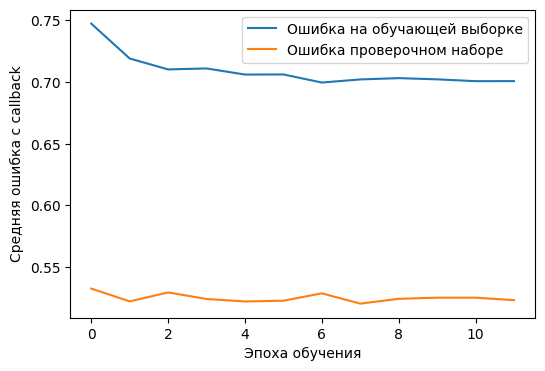

In [ ]:
model_func.compile(optimizer=Adam(learning_rate=1e-3), loss='mse', metrics=['mae'])

history_func = model_func.fit([x_num_scaled, x_data_cat],
                           y_scaled,
                           batch_size=256,
                           epochs=50,
                           validation_split=0.15,
                           verbose=1,
                           callbacks=[earlystop, reduceLROnPlateau, model_Checkpoint])
plot_history(history_func)
compare_sharp_loss(history_func)

2572/2572 [==============================] - 5s 2ms/step
Средняя абсолютная ошибка: 0.8360537187109907 

Реальное значение:   3.00  Предсказанное значение:   2.88  Разница:   0.12
Реальное значение:   3.00  Предсказанное значение:   2.88  Разница:   0.12
Реальное значение:   1.20  Предсказанное значение:   2.11  Разница:   0.91
Реальное значение:   2.00  Предсказанное значение:   2.08  Разница:   0.08
Реальное значение:   0.50  Предсказанное значение:   2.11  Разница:   1.61
Реальное значение:   3.50  Предсказанное значение:   2.08  Разница:   1.42
Реальное значение:   1.50  Предсказанное значение:   2.87  Разница:   1.37
Реальное значение:   0.00  Предсказанное значение:   0.79  Разница:   0.79
Реальное значение:   1.75  Предсказанное значение:   2.87  Разница:   1.12
Реальное значение:   0.00  Предсказанное значение:   0.79  Разница:   0.79


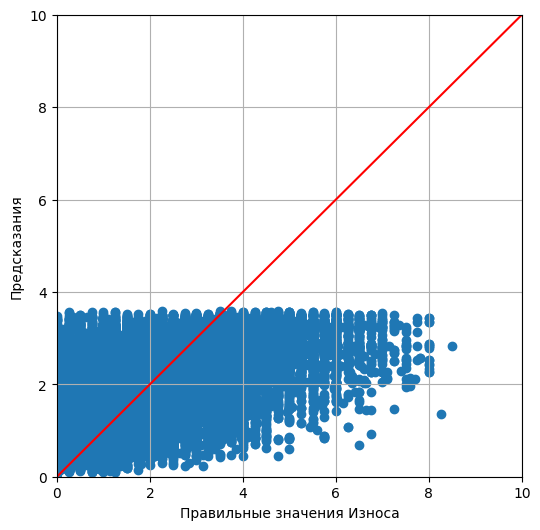

In [ ]:
eval_net(model_func, [x_num_scaled, x_data_cat], y_data.reshape(-1,1), y_scaler)

## Подбор гиперпараметров

In [ ]:
# построим новую модель FunctionalAPI

input1 = Input((x_train_num.shape[1],))
input2 = Input((x_train_cat.shape[1],))

x1_1 = input1                               # Ветка числовых данных
x1_1 = Dense(100, activation='sigmoid')(x1_1)
x1_1 = Dense(1000, activation='sigmoid')(x1_1)
x1_1 = Dropout(0.3)(x1_1)
x1_1 = Dense(2000, activation='sigmoid')(x1_1)
x1_1 = Dropout(0.2)(x1_1)
x1_1 = Dense(2000, activation='sigmoid')(x1_1)
x1_1 = Dense(2000, activation='sigmoid')(x1_1)
x1_1 = Dense(2000, activation='sigmoid')(x1_1)
x1_1 = Dense(2000, activation='sigmoid')(x1_1)
x1_1 = Dropout(0.3)(x1_1)
x1_1 = Dense(1, activation='linear')(x1_1)

x2_1 = input2                               # Ветка категориальных данных
x2_1 = Dense(150, activation='sigmoid')(x2_1)
x2_1 = Dense(650, activation="tanh")(x2_1)
x2_1 = Dropout(0.2)(x2_1)
x2_1 = Dense(1000, activation='sigmoid')(x2_1)
x2_1 = Dense(500, activation="tanh")(x2_1)
x2_1 = Dropout(0.3)(x2_1)

x_1 = concatenate([x1_1, x2_1])             # Объединение веток

x_1 = Dense(150, activation='sigmoid')(x_1)       # Промежуточный слой
x_1 = Dense(1000, activation='sigmoid')(x_1)
x_1 = Dropout(0.4)(x_1)
x_1 = Dense(650, activation='sigmoid')(x_1)
x_1 = Dense(1, activation='linear')(x_1)      # Финальный регрессирующий нейрон

# В Model передаются входы и выход
model_func_1 = Model((input1, input2), x_1)

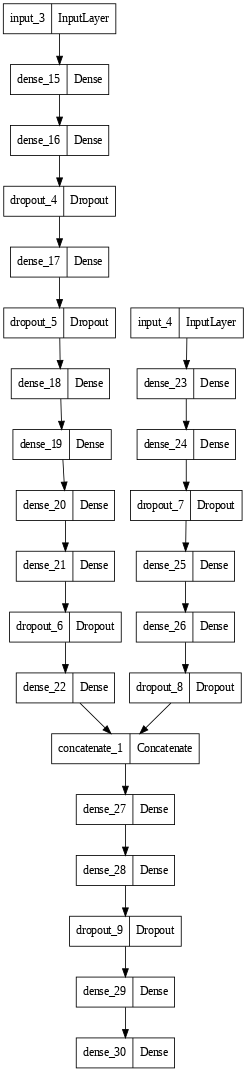

In [ ]:
# выведем схему построения модели
utils.plot_model(model_func_1, dpi=60)

In [ ]:
model_func_1.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 2)]                  0         []                            
                                                                                                  
 dense_15 (Dense)            (None, 100)                  300       ['input_3[0][0]']             
                                                                                                  
 dense_16 (Dense)            (None, 1000)                 101000    ['dense_15[0][0]']            
                                                                                                  
 dropout_4 (Dropout)         (None, 1000)                 0         ['dense_16[0][0]']            
                                                                                            

Epoch 1/50
511/515 [============================>.] - ETA: 0s - loss: 1.0697 - mae: 0.8367
Epoch 1: val_loss did not improve from 0.52040
515/515 [==============================] - 13s 14ms/step - loss: 1.0692 - mae: 0.8367 - val_loss: 0.8183 - val_mae: 0.7453 - lr: 1.0000e-04
Epoch 2/50
514/515 [============================>.] - ETA: 0s - loss: 1.0605 - mae: 0.8336
Epoch 2: val_loss did not improve from 0.52040
515/515 [==============================] - 7s 14ms/step - loss: 1.0602 - mae: 0.8334 - val_loss: 0.8653 - val_mae: 0.7730 - lr: 1.0000e-04
Epoch 3/50
515/515 [==============================] - ETA: 0s - loss: 1.0598 - mae: 0.8338
Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 3: val_loss did not improve from 0.52040
515/515 [==============================] - 7s 13ms/step - loss: 1.0598 - mae: 0.8338 - val_loss: 0.8252 - val_mae: 0.7500 - lr: 1.0000e-04
Epoch 4/50
511/515 [============================>.] - ETA: 0s - loss: 1.0501 - mae: 0.8304


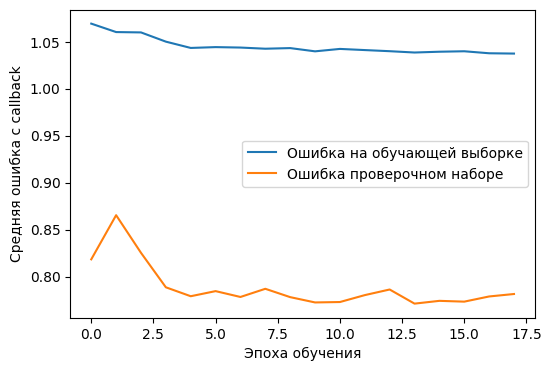

In [ ]:
model_func_1.compile(optimizer=Adam(learning_rate=1e-4), loss='mse', metrics=['mae'])

history_func_1 = model_func_1.fit([x_num_scaled, x_data_cat],
                           y_scaled,
                           batch_size=128,
                           epochs=50,
                           validation_split=0.2,
                           verbose=1,
                           callbacks=[earlystop, reduceLROnPlateau, model_Checkpoint])

compare_sharp_loss(history_func_1)

2572/2572 [==============================] - 7s 3ms/step
Средняя абсолютная ошибка: 1.0821092715172849 

Реальное значение:   3.00  Предсказанное значение:   1.93  Разница:   1.07
Реальное значение:   3.00  Предсказанное значение:   1.93  Разница:   1.07
Реальное значение:   1.20  Предсказанное значение:   1.93  Разница:   0.73
Реальное значение:   2.00  Предсказанное значение:   1.93  Разница:   0.07
Реальное значение:   0.50  Предсказанное значение:   1.93  Разница:   1.43
Реальное значение:   3.50  Предсказанное значение:   1.93  Разница:   1.57
Реальное значение:   1.50  Предсказанное значение:   1.93  Разница:   0.43
Реальное значение:   0.00  Предсказанное значение:   1.93  Разница:   1.93
Реальное значение:   1.75  Предсказанное значение:   1.93  Разница:   0.18
Реальное значение:   0.00  Предсказанное значение:   1.93  Разница:   1.93


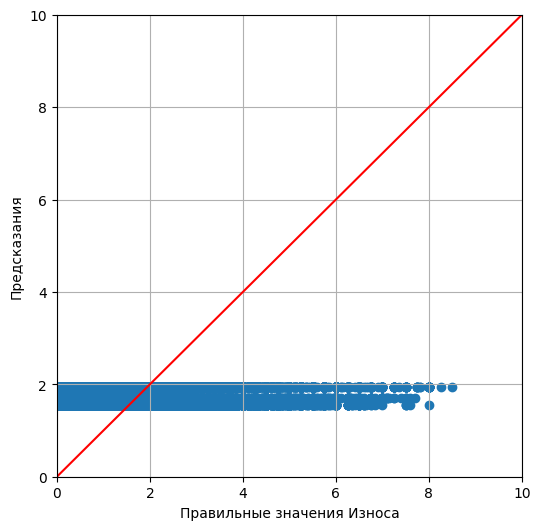

In [ ]:
eval_net(model_func_1, [x_num_scaled, x_data_cat], y_data.reshape(-1,1), y_scaler)

# Total + Износ

In [ ]:
#Загружаем датасет в переменную
dt_total = pd.read_excel('/content/РЖД.xlsx', sheet_name='TOTAL')
dt_total.head(10)

,Unnamed: 0,Н_Ло,Н_Се,Тип,Номер,Секция,Год,TOTAL,TOTAL_1,TOTAL_2,...,СЕВ_3,СЕВ_4,Ю-ВОСТ_1,Ю-ВОСТ_2,Ю-ВОСТ_3,Ю-ВОСТ_4,Ю-УР_1,Ю-УР_2,Ю-УР_3,Ю-УР_4
0,0,3425,28276,640,1,1,2022,72010,58993,556,...,0,0,2445,14,630,529,0,0,0,0
1,1,3425,20051,640,1,2,2022,72010,58993,556,...,0,0,2445,14,630,529,0,0,0,0
2,2,3335,21518,640,2,1,2022,73160,59476,691,...,0,0,2755,4,775,562,0,0,0,0
3,3,3335,26141,640,2,2,2022,73160,59476,691,...,0,0,2755,4,775,562,0,0,0,0
4,4,2612,20052,640,3,1,2022,92957,74382,838,...,0,0,4223,18,1087,895,0,0,0,0
5,5,2612,15616,640,3,2,2022,92957,74382,838,...,0,0,4223,18,1087,895,0,0,0,0
6,6,3085,21519,640,4,1,2022,104155,88030,727,...,0,0,1189,20,332,250,0,0,0,0
7,7,3085,21520,640,4,2,2022,104155,88030,727,...,0,0,1189,20,332,250,0,0,0,0
8,8,3086,21521,640,5,1,2022,106235,87100,836,...,0,0,5168,45,1262,976,0,0,0,0
9,9,3086,21522,640,5,2,2022,106235,87100,836,...,0,0,5168,45,1262,976,0,0,0,0


In [ ]:
dt_wearout['Год'] = pd.DatetimeIndex(dt_wearout['Конец']).year
dt_wearout

,Н_Ло,Н_КП,Н_Се,Номер,Секция,Н_серии,Начало,Конец,Период,Износ,Толщина гребня на начало,Толщина гребня на конец,Пробег за период,Пробег на начало,Пробег на конец,Год
0,4573,81329,18728,2,1,253,2022-01-25,2022-12-08,317,3.00,32.00,29.00,133132.0,1873288.0,2006420.0,2022
1,4573,114993,18728,2,1,253,2022-01-25,2022-12-08,317,3.00,32.00,29.00,133132.0,1873288.0,2006420.0,2022
2,4573,82697,18728,2,1,253,2022-01-25,2022-07-04,160,1.20,31.25,30.05,66482.0,1873288.0,1939770.0,2022
3,4573,82697,18728,2,1,253,2022-07-05,2022-12-08,156,2.00,31.50,29.50,66650.0,1939770.0,2006420.0,2022
4,4573,117134,18728,2,1,253,2022-01-25,2022-07-04,160,0.50,31.00,30.50,66482.0,1873288.0,1939770.0,2022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82280,1864,32827,11522,414,2,222,2023-04-20,2023-07-11,82,1.00,28.50,27.50,40319.0,650685.0,691004.0,2023
82281,1864,18266,11522,414,2,222,2023-01-27,2023-04-17,80,0.50,30.25,29.75,40657.0,610028.0,650685.0,2023
82282,1864,18266,11522,414,2,222,2023-04-20,2023-07-11,82,1.00,28.50,27.50,40319.0,650685.0,691004.0,2023
82283,1864,18274,11522,414,2,222,2023-01-27,2023-04-17,80,1.25,30.00,28.75,40657.0,610028.0,650685.0,2023


In [ ]:
# Объединение датасетов TOTAL и Износ
dt_wearout_total = pd.merge(dt_wearout.rename(columns={'Н_серии':'Тип'}),\
                            dt_total, left_on=['Н_Ло','Н_Се','Номер','Секция','Тип','Год'],\
                            right_on = ['Н_Ло','Н_Се','Номер','Секция','Тип','Год'])
dt_wearout_total

,Н_Ло,Н_КП,Н_Се,Номер,Секция,Тип,Начало,Конец,Период,Износ,...,СЕВ_3,СЕВ_4,Ю-ВОСТ_1,Ю-ВОСТ_2,Ю-ВОСТ_3,Ю-ВОСТ_4,Ю-УР_1,Ю-УР_2,Ю-УР_3,Ю-УР_4
0,4573,81329,18728,2,1,253,2022-01-25,2022-12-08,317,3.00,...,0,0,0,0,0,0,0,0,0,0
1,4573,114993,18728,2,1,253,2022-01-25,2022-12-08,317,3.00,...,0,0,0,0,0,0,0,0,0,0
2,4573,82697,18728,2,1,253,2022-01-25,2022-07-04,160,1.20,...,0,0,0,0,0,0,0,0,0,0
3,4573,82697,18728,2,1,253,2022-07-05,2022-12-08,156,2.00,...,0,0,0,0,0,0,0,0,0,0
4,4573,117134,18728,2,1,253,2022-01-25,2022-07-04,160,0.50,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79110,1864,32827,11522,414,2,222,2023-04-20,2023-07-11,82,1.00,...,3913,2821,0,0,0,0,0,0,0,0
79111,1864,18266,11522,414,2,222,2023-01-27,2023-04-17,80,0.50,...,3913,2821,0,0,0,0,0,0,0,0
79112,1864,18266,11522,414,2,222,2023-04-20,2023-07-11,82,1.00,...,3913,2821,0,0,0,0,0,0,0,0
79113,1864,18274,11522,414,2,222,2023-01-27,2023-04-17,80,1.25,...,3913,2821,0,0,0,0,0,0,0,0


In [ ]:
dt_wt = pd.get_dummies(dt_wearout_total.drop(['Н_Ло', 'Н_КП', 'Н_Се', 'Номер',
                                              'Начало', 'Конец',
                                              'Толщина гребня на начало',
                                              'Толщина гребня на конец',
                                              'Пробег на начало',
                                              'Пробег на конец', 'Unnamed: 0'],\
                                              axis=1),columns=['Секция','Тип',
                                                                        'Год'])

dt_wt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 79115 entries, 0 to 79114
Data columns (total 86 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Период            79115 non-null  int64  
 1   Износ             79115 non-null  float64
 2   Пробег за период  79115 non-null  float64
 3   TOTAL             79115 non-null  int64  
 4   TOTAL_1           79115 non-null  int64  
 5   TOTAL_2           79115 non-null  int64  
 6   TOTAL_3           79115 non-null  int64  
 7   TOTAL_4           79115 non-null  int64  
 8   RES_1             79115 non-null  int64  
 9   RES_2             79115 non-null  int64  
 10  RES_3             79115 non-null  int64  
 11  RES_4             79115 non-null  int64  
 12  В-СИБ_1           79115 non-null  int64  
 13  В-СИБ_2           79115 non-null  int64  
 14  В-СИБ_3           79115 non-null  int64  
 15  В-СИБ_4           79115 non-null  int64  
 16  ГОРЬК_1           79115 non-null  int64 

In [ ]:
# изменим тип данных
dt_wt = dt_wt.astype({'Секция_1':'int64','Секция_2':'int64','Секция_3':'int64',
                      'Тип_222':'int64','Тип_253':'int64','Тип_640':'int64',
                      'Год_2020':'int64','Год_2021':'int64','Год_2022':'int64',
                      'Год_2023':'int64'})

In [ ]:
dt_wt

,Период,Износ,Пробег за период,TOTAL,TOTAL_1,TOTAL_2,TOTAL_3,TOTAL_4,RES_1,RES_2,...,Секция_1,Секция_2,Секция_3,Тип_222,Тип_253,Тип_640,Год_2020,Год_2021,Год_2022,Год_2023
0,317,3.00,133132.0,153482,99363,15820,24543,13756,6,6,...,1,0,0,0,1,0,0,0,1,0
1,317,3.00,133132.0,153482,99363,15820,24543,13756,6,6,...,1,0,0,0,1,0,0,0,1,0
2,160,1.20,66482.0,153482,99363,15820,24543,13756,6,6,...,1,0,0,0,1,0,0,0,1,0
3,156,2.00,66650.0,153482,99363,15820,24543,13756,6,6,...,1,0,0,0,1,0,0,0,1,0
4,160,0.50,66482.0,153482,99363,15820,24543,13756,6,6,...,1,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79110,82,1.00,40319.0,111673,76890,3044,22535,9204,5,5,...,0,1,0,1,0,0,0,0,0,1
79111,80,0.50,40657.0,111673,76890,3044,22535,9204,5,5,...,0,1,0,1,0,0,0,0,0,1
79112,82,1.00,40319.0,111673,76890,3044,22535,9204,5,5,...,0,1,0,1,0,0,0,0,0,1
79113,80,1.25,40657.0,111673,76890,3044,22535,9204,5,5,...,0,1,0,1,0,0,0,0,0,1


In [ ]:
# найдем количество ненулевых значений с ценой деления 0.01
dt_wt['Износ'][(dt_wt['Износ']%0.01==0)&(dt_wt['Износ']!=0)]

1924     0.08
2138     2.56
2193     0.04
2446     0.01
3197     0.04
73466    0.32
Name: Износ, dtype: float64

In [ ]:
# найдем количество нулевых значений с ценой деления 0.01
dt_wt['Износ'][(dt_wt['Износ']%0.01==0)&(dt_wt['Износ']==0)]

7        0.0
9        0.0
13       0.0
17       0.0
42       0.0
        ... 
79090    0.0
79092    0.0
79094    0.0
79096    0.0
79098    0.0
Name: Износ, Length: 7388, dtype: float64

In [ ]:
# данные о пробеге по кривым на участках
dt_dist = dt_wt.drop(columns=['TOTAL','TOTAL_1','TOTAL_2','TOTAL_3','TOTAL_4',
                              'RES_1','RES_2','RES_3','RES_4','Секция_1',
                              'Секция_2','Секция_3','Тип_222','Тип_253','Тип_640',
                              'Год_2020','Год_2021','Год_2022','Год_2023',
                              'Износ','Период','Пробег за период'])
dt_dist

,В-СИБ_1,В-СИБ_2,В-СИБ_3,В-СИБ_4,ГОРЬК_1,ГОРЬК_2,ГОРЬК_3,ГОРЬК_4,ДВОСТ_1,ДВОСТ_2,...,СЕВ_3,СЕВ_4,Ю-ВОСТ_1,Ю-ВОСТ_2,Ю-ВОСТ_3,Ю-ВОСТ_4,Ю-УР_1,Ю-УР_2,Ю-УР_3,Ю-УР_4
0,69503,10839,16698,9392,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,69503,10839,16698,9392,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,69503,10839,16698,9392,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,69503,10839,16698,9392,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,69503,10839,16698,9392,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79110,0,0,0,0,0,0,0,0,0,0,...,3913,2821,0,0,0,0,0,0,0,0
79111,0,0,0,0,0,0,0,0,0,0,...,3913,2821,0,0,0,0,0,0,0,0
79112,0,0,0,0,0,0,0,0,0,0,...,3913,2821,0,0,0,0,0,0,0,0
79113,0,0,0,0,0,0,0,0,0,0,...,3913,2821,0,0,0,0,0,0,0,0


In [ ]:
# данные о пробеге по кривым на участках
dt_dist.shape

(79115, 64)

In [ ]:
from keras.layers import Embedding
x = Input(shape=dt_dist.shape[1])
e = Embedding(5, 5, mask_zero=True)(x)

m = Model(inputs=x, outputs=e)
p = m.predict(dt_dist)
print(p.shape)
print(p)

NameError: ignored

In [ ]:
m.summary()

NameError: ignored

In [ ]:
x = Input(shape=dt_dist.shape[1])
e = Embedding(64, 3, mask_zero=True)(x)

m = Model(inputs=x, outputs=e)
p = m.predict(dt_dist)
print(p.shape)
print(p)

2473/2473 [==============================] - 3s 1ms/step
(79115, 64, 3)
[[[ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  ...
  [ 0.04002422 -0.04842639 -0.0406052 ]
  [ 0.04002422 -0.04842639 -0.0406052 ]
  [ 0.04002422 -0.04842639 -0.0406052 ]]

 [[ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  ...
  [ 0.04002422 -0.04842639 -0.0406052 ]
  [ 0.04002422 -0.04842639 -0.0406052 ]
  [ 0.04002422 -0.04842639 -0.0406052 ]]

 [[ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  ...
  [ 0.04002422 -0.04842639 -0.0406052 ]
  [ 0.04002422 -0.04842639 -0.0406052 ]
  [ 0.04002422 -0.04842639 -0.0406052 ]]

 ...

 [[ 0.04002422 -0.04842639 -0.0406052 ]
  [ 0.04002422 -0.04842639 -0.0406052 ]
  [ 0.04002422 -0.04842639 -0.0406052 ]
  ...
  [ 0.04002422 -0.04842639 -0.0406052 ]
  [ 0.040024

In [ ]:
m.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 64)]              0         
                                                                 
 embedding_9 (Embedding)     (None, 64, 3)             192       
                                                                 
Total params: 192 (768.00 Byte)
Trainable params: 192 (768.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
decoderForOutput = np.array(dt_dist.values)

In [ ]:
vocabularySize = int(dt_dist.max().sort_values().tail(1).values)

In [ ]:
from tensorflow.keras.layers import Dense, Embedding, LSTM, Input
# Создадим энкодер

encoderInputs = Input(shape=(None , ))                                               # Добавим входной слой
encoderEmbedding = Embedding(vocabularySize, 200 , mask_zero=True)(encoderInputs)    # Добавим эмбеддинг
encoderOutputs, state_h , state_c = LSTM(200, return_state=True)(encoderEmbedding)   # Добавим LSTM
encoderStates = [state_h, state_c]                                                   # Соберем выходы lstm  в список

In [ ]:
# Создадим декодер

decoderInputs = Input(shape=(None, ))                                                # Добавим входной слой
decoderEmbedding = Embedding(vocabularySize, 200, mask_zero=True)(decoderInputs)    # Добавим эмбеддинг
decoderLSTM = LSTM(200, return_state=True, return_sequences=True)                    # Создадим LSTM слой
decoderOutputs , _ , _ = decoderLSTM(decoderEmbedding, initial_state=encoderStates) # Прогоним выход embedding через LSTM
decoderDense = Dense(vocabularySize, activation='softmax')                           # Создадим dense слой
output = decoderDense(decoderOutputs)                                               # Прогоним  выход LSTM через DENSE

In [ ]:
# Построим модель

model = Model([encoderInputs, decoderInputs], output)                                # Собираем модель
model.compile(optimizer=RMSprop(), loss='sparse_categorical_crossentropy')           # Компилиуем модель
print(model.summary())                                                               # Выведем на экран информацию о построенной модели нейросети

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_21 (InputLayer)       [(None, None)]               0         []                            
                                                                                                  
 input_22 (InputLayer)       [(None, None)]               0         []                            
                                                                                                  
 embedding_13 (Embedding)    (None, None, 200)            3699740   ['input_21[0][0]']            
                                                          0                                       
                                                                                                  
 embedding_14 (Embedding)    (None, None, 200)            3699740   ['input_22[0][0]']     

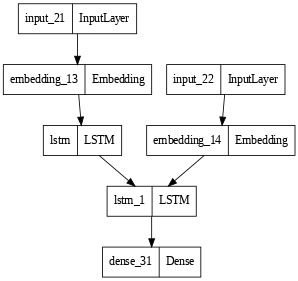

In [ ]:
# выведем схему построения модели
utils.plot_model(model, dpi=60)

In [ ]:
# Запустим обучение
model.fit([encoderForInput , decoderForInput], decoderForOutput, batch_size=256, epochs=30)

NameError: ignored